# Caso Práctico 4.4:  Clasificación de textos con Scikit-Learn

* En este notebook vamos a ver como clasificar una serie de Tweets en Ingles sobre críticas a los productos de Apple.


* Estos tweets estan clasificados como: *positivos*, *neutros* o *negativos*


* El este notebook realizaremos los siguientes pasos:
    
    1. Carga de los datos (tweets)
    2. Normalización (en ingles) de los tweets
    3. Creación de la Bolsa de Palabras
    4. Particionado de Datos
    5. Creación de modelos
        - Multinomial Naive Bayes
        - Bernoulli Naive Bayes
        - Regresion Logistica
        - Support Vector Machine
        - Random Forest <sup>(*)Meta-Modelo</sup>
    6. Evaluación de los modelos

<hr>


## Carga de Datos


* El primer paso que vamos a realizar es el de cargar los datos. Para ello ***leeremos el csv con pandas*** (pasandolo a un dataframe) y posteriormente lo transformaremos en una lista de tuplas (*tweets*) donde cada tupla esta formada por:
    - **Posición 0**: Tweet
    - **Posición 1**: Polaridad (Positivo | Neutro | Negativo)

In [1]:
import pandas as pd
tweets_file = './data/Apple_Tweets.csv'
df = pd.read_csv(tweets_file, header=None)
tweets = [tuple(x) for x in df.values]
print('Número de Tweets Cargados: {num}'.format(num=len(tweets)))

Número de Tweets Cargados: 3804


<hr>


## Normalización

* Para este ejemplo haremos uso de ***spaCy***, pero en este caso tenemos que utilizar (e importar) el modelo para Inglés. Para ello: debemos de abrir un terminal en python y ejecutar lo siguiente para descargar el modelo en Ingles (*NOTA: los que uséis conda, tener activado el entorno*).


```
>> python3 -m spacy download en_core_web_sm
```


<img src="./imgs/010_spacy_en_download.png" style="width: 600px;"/>


* Para ***normalizar*** los tweets realizaremos las siguientes acciones:
    1. Pasamos las frases a minúsculas.
    2. Eliminamos los signos de puntuación.
    3. Eliminamos las palabras con menos de 3 caracteres.
    4. Eliminamos las Stop-Words.
    5. Eliminamos las palabras que empiecen por '@' o 'http'.
    6. Pasamos la palabra a su lema


* Todos estos pasos los vamos a realizar en una misma función.


* ***NOTA***: *De cara a la normalización de textos se pueden realizar más acciones que las que vamos a realizar, pero con estas serán más que suficientes para realizar un ejercicio con fines didácticos*
    

In [2]:
import spacy
nlp = spacy.load('en_core_web_sm')

# Divido los datos en dos listas 
#     X: los tweets
#     y: target (polaridad)

X = [doc[0] for doc in tweets]
y = [doc[1] for doc in tweets]

def normalize(sentenses):
    """normalizamos la lista de frases y devolvemos la misma lista de frases normalizada"""
    for index, sentense in enumerate(sentenses):
        sentense = nlp(sentense.lower()) # Paso la frase a minúsculas y a un objeto de la clase Doc de Spacy
        sentenses[index] = " ".join([word.lemma_ for word in sentense if (not word.is_punct)
                                     and (len(word.text) > 2) and (not word.is_stop) 
                                     and (not word.text.startswith('@')) and (not word.text.startswith('http'))])
    return sentenses

# Normalizamos las frases
X = normalize(X)

<hr>


## Bolsa de Palabras


* El siguiente paso es transformar los tweets a una bolsa de palabras de frecuencias para que sirva de entrada al modelo.


* Dado que ya estamos trabajando con un corpus relativamente grande, es necesario reducir el diccionario de palabras (no confundir con un diccionario Python) para trabajar solo con las palabras más relevantes.


* La implementación de la clase "*CountVectorizer*" de scikit, permite quedarnos con las palabras más relevante. Para ello podemos utilizar dos parámetros que son:
    - **max_features**: Con este parámetro le indicamos que nos seleccione la '*X*' palabras más frecuentes del corpus. En este ejemplo **seleccionaremos las 1000 más frecuentes**.
    - **min_df**: Con este parámetro le indicamos el número mínimo de documentos en la que tiene que aparecer la palabra para que se incluya en la bolsa de palabras. En este ejemplo **seleccionaremos 3 documentos** (tweets).
    

* ***NOTA***: para más información podéis mirar la documentación de la clase "*CountVectorizer*" en: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
    

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000, min_df=3)

# Pasamos los tweets normalizados a Bolsa de palabras
X = vectorizer.fit_transform(X)

<hr>


## Particionado de Datos (Train y Test)

* Vamos a particionar los datos en conjunto de Train y Test.


* Para este ejemplo nos vamos a quedar con:
    - 80% de datos de entrenamiento
    - 20% de datos de test

In [4]:
from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('Número de Tweets para el entrenamiento: {num}'.format(num=X_train.shape[0]))
print('Número de Tweets para el test: {num}'.format(num=X_test.shape[0]))

Número de Tweets para el entrenamiento: 3043
Número de Tweets para el test: 761


<hr>


## Creacción del Modelo


* Una vez tenemos creada la bolsa de palabras, podemos usar cualquier algoritmo de aprendizaje para la clasificación.


* Para este ejemplo vamos a usar los siguientes algoritmos de aprendizaje:

    - Multinomial Naive Bayes: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
    - Bernoulli Naive Bayes: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html
    - Regresion Logistica: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    - Support Vector Machine Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    - Random Forest (ensemble): https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    

* Para esta caso vamos a crear el modelo y calcular el accuracy para los datos de entrenamiento y tener una idea de que modelo puede funciona mejor:

In [5]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

mnb = MultinomialNB()
bnb = BernoulliNB()
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
svm_lin = SVC(kernel='linear')
svm_rbf = SVC(kernel='rbf')
rf_50 = RandomForestClassifier(n_estimators=500, bootstrap=True, criterion='gini', max_depth=50, random_state=0)

clasificadores = {'Multinomial NB': mnb,
                  'Bernoulli NB': bnb,
                  'Regresion Logistica': lr,
                  'SVM lineal': svm_lin,
                  'SVM Kernel rbf': svm_rbf,
                  'Random Forest d_50': rf_50}


# Ajustamos los modelos y calculamos el accuracy para los datos de entrenamiento
for k, v in clasificadores.items():
    print ('CREANDO MODELO: {clas}'.format(clas=k))
    v.fit(X_train, y_train)

CREANDO MODELO: Multinomial NB
CREANDO MODELO: Bernoulli NB
CREANDO MODELO: Regresion Logistica
CREANDO MODELO: SVM lineal
CREANDO MODELO: SVM Kernel rbf


C:\Users\David\Documents\python37_IA\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CREANDO MODELO: Random Forest d_50


<hr>


## Evaluación del Modelo


* Para cada uno de los modelos vamos a calcular las siguientes métricas de evaluación:

    1. **Accuracy**
    2. **Precision**
    3. **Recall**
    4. **F1**

In [6]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

def evaluation(model, name, X_train, y_train, X_test, y_test):
    """
    Función de devuelve en un diccionario las métricas de evaluación de 
    Accuracy, Precision, Recall y F1 para los conjuntos de datos de entrenamiento y test
        model: modelo a evaluar
        name: nombre del modelo
        X_train: Variables de entrada del conjunto de datos de entrenamiento
        y_train: Variable de salida del conjunto de datos de entrenamiento
        X_test: Variables de entrada del conjunto de datos de test
        y_test: Variable de salida del conjunto de datos de test
        return: diccionario con el nombre del modelo y el valor de las métricas
    """
    model_dict = {}
    model_dict['name'] = name
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    model_dict['accuracy_train'] = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    model_dict['accuracy_tests'] = accuracy_score(y_true=y_test, y_pred=y_pred_test)
    model_dict['precision_train'] = precision_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['precision_tests'] = precision_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    model_dict['recall_train'] = recall_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['recall_tests'] = recall_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    model_dict['f1_train'] = f1_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['f1_tests'] = f1_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    
    return model_dict


# Calculamos las métricas de los modelos por separado
evaluacion = list()
for key, model in clasificadores.items():
    evaluacion.append(evaluation(model=model, name=key, 
                                 X_train=X_train, y_train=y_train,
                                 X_test=X_test, y_test=y_test))

# Pasamos los resultados a un DataFrame para visualizarlos mejor
df = pd.DataFrame.from_dict(evaluacion)
df.set_index("name", inplace=True)
df

C:\Users\David\Documents\python37_IA\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\David\Documents\python37_IA\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,accuracy_train,accuracy_tests,precision_train,precision_tests,recall_train,recall_tests,f1_train,f1_tests
name,,,,,,,,
Multinomial NB,0.776865,0.717477,0.780823,0.724340,0.776865,0.717477,0.777988,0.720319
Bernoulli NB,0.752875,0.709593,0.764600,0.721002,0.752875,0.709593,0.753723,0.711783
Regresion Logistica,0.867565,0.746386,0.873180,0.741151,0.867565,0.746386,0.864078,0.736709
SVM lineal,0.877752,0.755585,0.882171,0.751098,0.877752,0.755585,0.875036,0.748751
SVM Kernel rbf,0.565889,0.578187,0.320230,0.334300,0.565889,0.578187,0.409008,0.423650
Random Forest d_50,0.848833,0.743758,0.877940,0.764072,0.848833,0.743758,0.841760,0.721168


* Representamos las métricas para los diferentes modelos en un gráfico de barras:

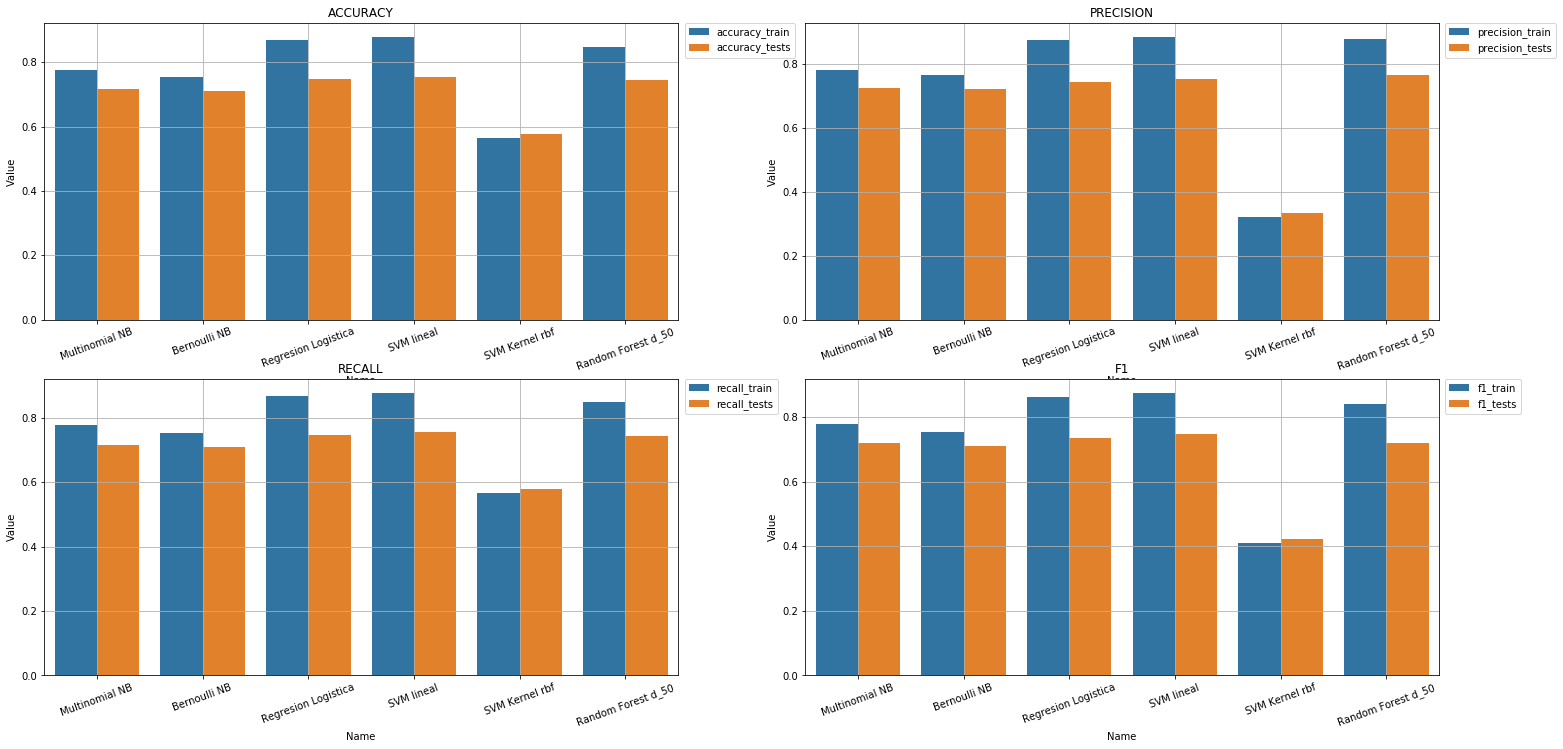

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Métricas a pintar
METRICS = ["accuracy", "precision", "recall", "f1"]

# Transformamos el dataframe para pintar las gráficas con seaborn
df_plot = df.reset_index().melt(id_vars='name').rename(columns=str.title)

plt.figure(figsize=(25, 12))
pos = 1
for metric in METRICS:
    # Filtramos la métrica a pintar
    df_aux = df_plot[df_plot['Variable'].str.contains(metric)]
    
    # Pintamos la gráfica en su posición 2x2
    plt.subplot(2, 2, pos)
    sns.barplot(x='Name', y='Value', hue='Variable', data=df_aux)
    plt.title(metric.upper())
    plt.grid()
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.xticks(rotation=20)
    pos += 1
plt.show()

* Veamos las matrices de confusión de los modelos

Obteniendo Matriz de Confusión de: Multinomial NB
Obteniendo Matriz de Confusión de: Bernoulli NB
Obteniendo Matriz de Confusión de: Regresion Logistica
Obteniendo Matriz de Confusión de: SVM lineal
Obteniendo Matriz de Confusión de: SVM Kernel rbf
Obteniendo Matriz de Confusión de: Random Forest d_50


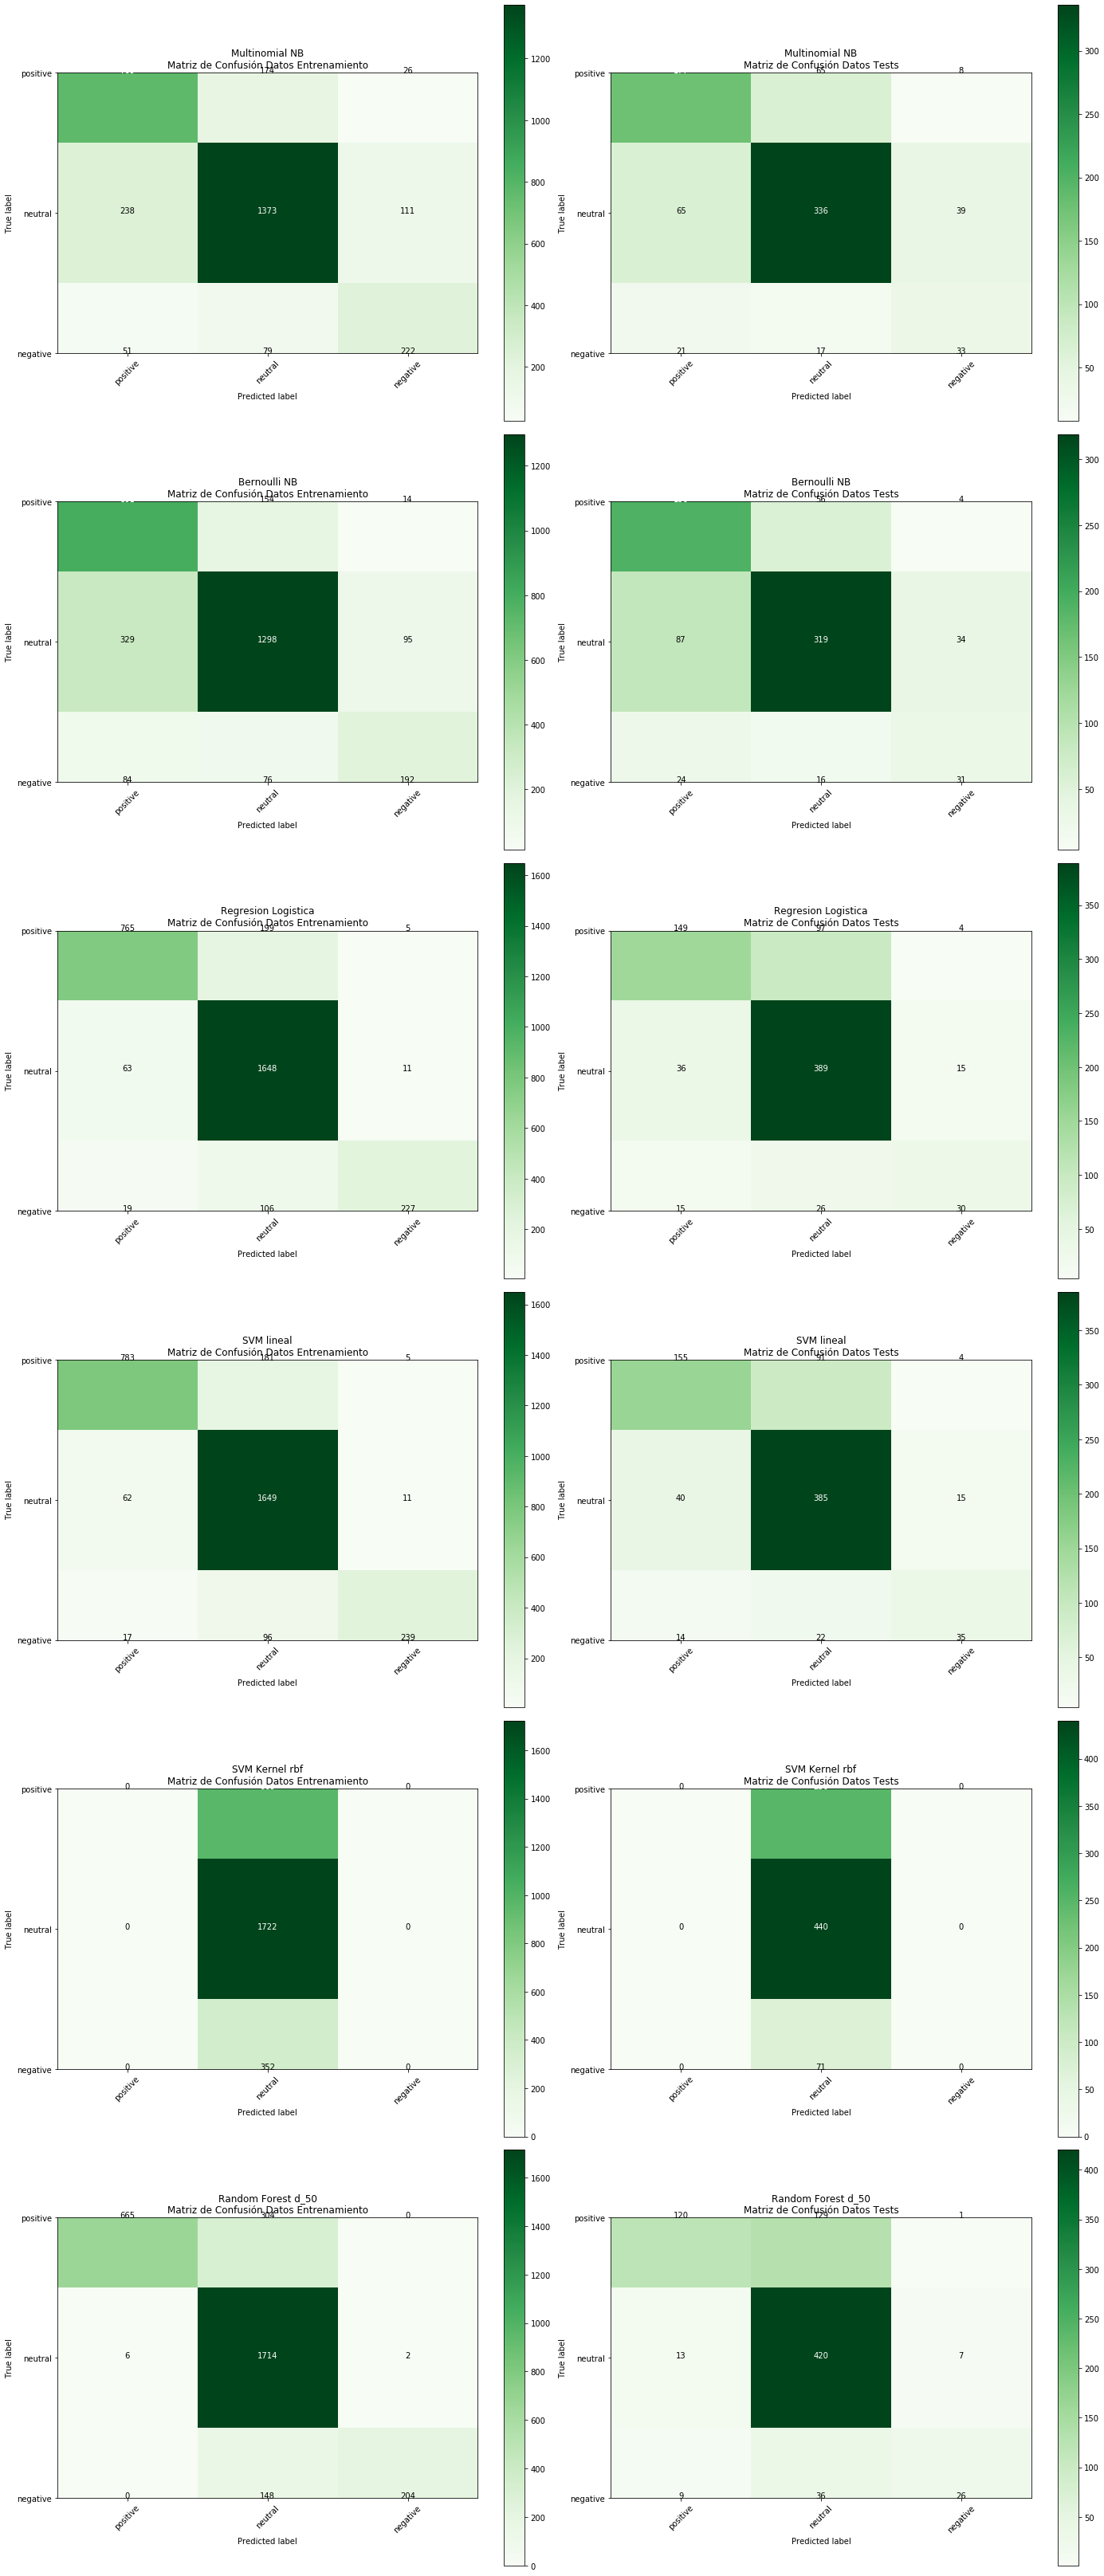

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

from sklearn.metrics import confusion_matrix

# Obtenemos las Matrices de confusión
msc = list()
for k, v in clasificadores.items():
    print ('Obteniendo Matriz de Confusión de: {model}'.format(model=k))
    model = {}
    model['name'] = k
    y_pred_train = v.predict(X_train)
    y_pred_test = v.predict(X_test)
    model['confusion_matrix_train'] = confusion_matrix(y_true=y_train, y_pred=y_pred_train)
    model['confusion_matrix_test'] = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
    msc.append(model)

    
# Definimos el heatmap de la matriz de confusión
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Pintamos las matrices de confusión
plt.figure(figsize=(20, 45))
pos = 0
for mc in msc:
    pos += 1
    plt.subplot(6, 2, pos)
    plot_confusion_matrix(mc['confusion_matrix_train'], classes=['positive', 'neutral', 'negative'], 
                          title='{}\nMatriz de Confusión Datos Entrenamiento'.format(mc['name']))
    pos += 1
    plt.subplot(6, 2, pos)
    plot_confusion_matrix(mc['confusion_matrix_test'], classes=['positive', 'neutral', 'negative'], 
                          title='{}\nMatriz de Confusión Datos Tests'.format(mc['name'] ))
plt.show()